In [1]:
from PIL import Image
from pathlib import Path
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# Prepocess to generate seven image

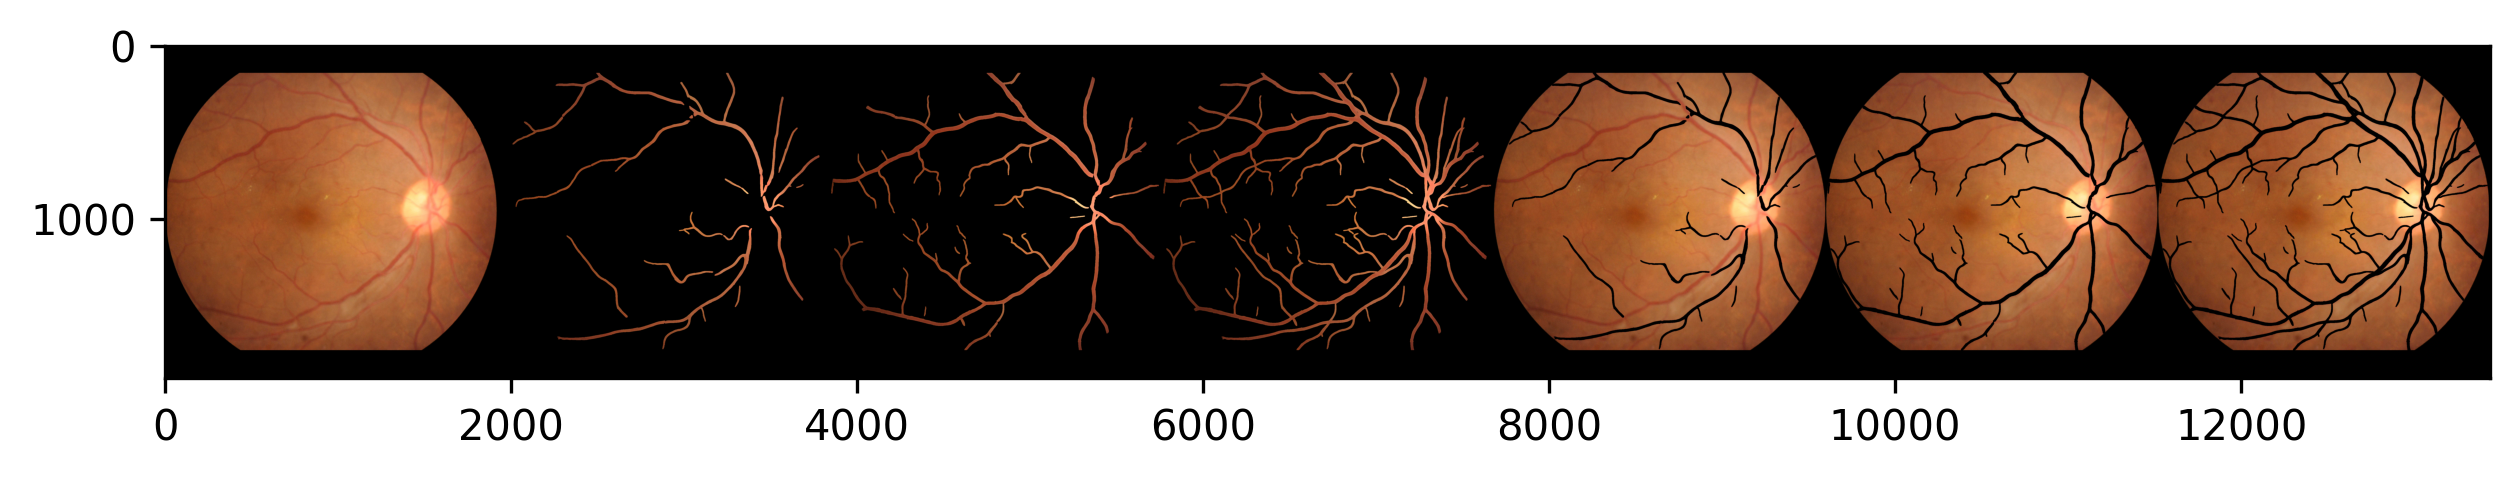

In [15]:
def generate_contribution_image_from_ori(img, av,name):
    """
    Generate contribution image from original image based on some conditions.
    Parameters:
    img (numpy array): Original image.
    av (numpy array): Array with specific conditions.
    output: Output parameter (not used in this function).
    input: Input parameter (not used in this function).
    Returns:
    Tuple of numpy arrays: Processed images based on conditions.
    """
    # Define the kernel for dilation
    kernel = np.ones((5, 5), np.uint8)
    # Initialize labels for vessels, A, and V
    LabelVessel = np.zeros((av.shape[0], av.shape[1]), dtype=np.uint8)
    LabelA = np.zeros((av.shape[0], av.shape[1]), dtype=np.uint8)
    LabelV = np.zeros((av.shape[0], av.shape[1]), dtype=np.uint8)
    # Update labels based on conditions
    LabelA[(av[:, :, 2] > 128) | (av[:, :, 1] > 128)] = 1
    LabelA[(av[:, :, 2] > 128) & (av[:, :, 1] > 128) & (av[:, :, 0] > 128)] = 0
    LabelV[(av[:, :, 1] > 128) | (av[:, :, 0] > 128)] = 1
    LabelV[(av[:, :, 2] > 128) & (av[:, :, 1] > 128) & (av[:, :, 0] > 128)] = 0
    LabelVessel[(av[:, :, 2] > 128) | (av[:, :, 1] > 128) | (av[:, :, 0] > 128)] = 1
    # Create copies of the original image
    image_na = img.copy()
    image_nv = img.copy()
    image_nav = img.copy()
    image_a = img.copy()
    image_v = img.copy()
    image_av = img.copy()
    # Perform dilation and update images based on labels
    LabelA_d = cv2.dilate(LabelA, kernel=kernel)
    image_na[LabelA_d == 1] = 0
    image_nv = img.copy()
    LabelV_d = cv2.dilate(LabelV, kernel=kernel)
    image_nv[LabelV_d == 1] = 0
    image_nav = img.copy()
    LabelVessel_d = cv2.dilate(LabelVessel, kernel=kernel)
    image_nav[LabelVessel_d == 1] = 0

    image_a = img.copy()
    image_nav[LabelVessel_d == 1]
    image_a[LabelA_d != 1] = 0
    # color_to_fill = 0
    # mask = cv2.inRange(image_a, color_to_fill, color_to_fill)
    # image_na = cv2.inpaint(image_na, mask, 5, cv2.INPAINT_TELEA)
    image_v = img.copy()
    image_v[LabelV_d != 1] = 0

    image_av = img.copy()
    image_av[LabelVessel_d != 1] = 0

    vis = []
    vis.append(img)
    vis.append(image_a)
    vis.append(image_v)
    vis.append(image_av)
    vis.append(image_na)
    vis.append(image_nv)
    vis.append(image_nav)
    plt.figure(figsize=(10, 10),dpi=300)  
    plt.imshow(np.hstack(vis))
    plt.show()
    


    
input_img = 'reproduction/source/preprocess/IDRiD_05_2_tr_082_image.png'
input_av = 'reproduction/source/preprocess/IDRiD_05_2_tr_082_av.png'

img_list = [input_img]
av_list = [input_av]

for ind,name in enumerate(img_list):
    #assert name == av_list[ind]
    img = cv2.imread(name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    test_image_height = img.shape[0]
    test_image_width = img.shape[1]
    if min(test_image_height,test_image_width)<=256:
        test_image_width=512
        test_image_height = int(test_image_width * (img.shape[0] / img.shape[1]))
        img = cv2.resize(img, (test_image_width,test_image_height))
    
    elif max(test_image_height,test_image_width)>=1920:
        test_image_width = 1920
        test_image_height = int(test_image_width * (img.shape[0] / img.shape[1]))
        img = cv2.resize(img, (test_image_width,test_image_height))
    elif max(test_image_height,test_image_width)>=1920:
        test_image_width = 1920
        test_image_height = int(test_image_width * (img.shape[0] / img.shape[1]))
        img = cv2.resize(img, (test_image_width,test_image_height))
    av = cv2.imread(av_list[ind])
    generate_contribution_image_from_ori(img,av,name=name)

In [21]:
from pretrain.AV.Preprocessing.generate_patch_selection_for_RIP_all_b_v2 import patchJudge,check_overlap
import cv2
from PIL import Image
from tqdm import tqdm,trange
import argparse
from skimage import morphology
import random
import pandas as pd

---------------------------------------


In [24]:
def patch_select_for_RIP(patch_size, Mask, LabelA, LabelV, LabelVessel):
    '''
    :param patch_size:
    :param Mask: 3HW
    :param LabelA: HW
    :param LabelV: HW
    :param LabelVessel: HW
    :param av_type: 'a_or_v' or 'only_a' or 'only_v' or 'only_av'
    0 represents only_a
    1 represents only_v
    2 represents only_av
    '''
    H, W = LabelA.shape
    Ve_rate_back = np.count_nonzero(LabelVessel) / (H * W)
    V_rate_back = np.count_nonzero(LabelV) / (H * W)
    A_rate_back = np.count_nonzero(LabelA) / (H * W)
    rate = min(Ve_rate_back, V_rate_back, A_rate_back)

    if type==2 or patch_size>=256:
        limit = max(int(min(patch_size,256) * min(patch_size,256) * rate),150)
    else:
        if dataset_name=='AV_DRIVE':
            limit=100
        else:
            limit = 150

    skel = Mask[2, :, :]

    skels = np.argwhere(skel)
    find_patch = False
    dot_pix = np.random.randint(0, len(skels))
    y_aixs = skels[dot_pix][0]
    x_aixs = skels[dot_pix][1]
    roi_area_x_left = max(0, x_aixs - patch_size)
    roi_area_y_left = max(0, y_aixs - patch_size)
    roi_area_x_right = min(x_aixs + patch_size, LabelVessel.shape[1])
    roi_area_y_right = min(y_aixs + patch_size, LabelVessel.shape[0])

    y = np.random.randint(roi_area_y_left, roi_area_y_right - patch_size + 1)
    x = np.random.randint(roi_area_x_left, roi_area_x_right - patch_size + 1)

    cn = 0
    limit_cn = 1000
    find_patch,av_type = patchJudge(Mask, LabelA, LabelV, LabelVessel, y, x, patch_size, patch_size, limit=limit)
    while (not find_patch) and cn < limit_cn:
        find_patch, av_type = patchJudge(Mask, LabelA, LabelV, LabelVessel, y, x, patch_size, patch_size, limit=limit)
        if cn % 100 == 0 and cn > 0:
            dot_pix = np.random.randint(0, skels.shape[0])
            y_aixs = skels[dot_pix][0]  # w
            x_aixs = skels[dot_pix][1]  # h
            roi_area_x_left = max(0, x_aixs - patch_size)
            roi_area_y_left = max(0, y_aixs - patch_size)
            roi_area_x_right = min(x_aixs + patch_size, LabelVessel.shape[1])
            roi_area_y_right = min(y_aixs + patch_size, LabelVessel.shape[0])
        y = np.random.randint(roi_area_y_left, roi_area_y_right - patch_size + 1)
        x = np.random.randint(roi_area_x_left, roi_area_x_right - patch_size + 1)
        cn+=1
    if cn < limit_cn:
        find_patch = True

    return y, x,patch_size,find_patch,av_type,roi_area_y_left,roi_area_x_left,roi_area_y_right,roi_area_x_right

# representaive instance generation

100%|██████████| 1/1 [00:00<00:00, 45.57it/s]


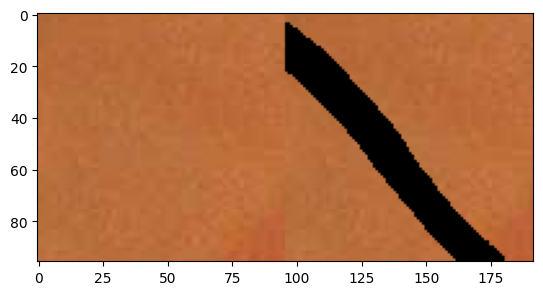

100%|██████████| 1/1 [00:00<00:00, 44.36it/s]


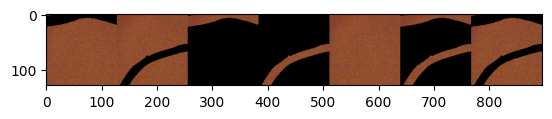

100%|██████████| 1/1 [00:00<00:00, 37.18it/s]


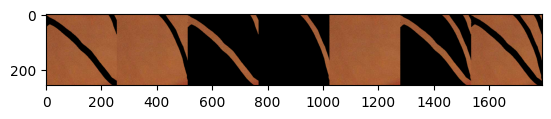

100%|██████████| 1/1 [00:00<00:00, 20.10it/s]


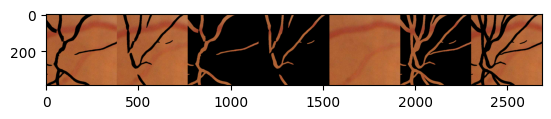

100%|██████████| 1/1 [00:00<00:00, 21.79it/s]


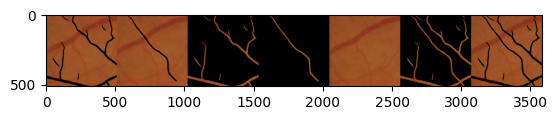

In [31]:
av = cv2.imread(input_av)
image = cv2.imread(input_img)
av_path_list = []
patch_x_y_list=[]
patch_list_df = []
dataset_name = 'expample'
av_path = input_av
image_bak = image.copy()
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
LabelVessel = np.zeros((av.shape[0], av.shape[1]), dtype=np.uint8)
LabelA = np.zeros((av.shape[0], av.shape[1]), dtype=np.uint8)
LabelV = np.zeros((av.shape[0], av.shape[1]), dtype=np.uint8)
Mask = np.zeros((3,av.shape[0], av.shape[1]), dtype=np.uint8)

LabelA[(av[:, :, 2] == 255) | (av[:, :, 1] == 255)] = 1
LabelA[(av[:, :, 2] == 255) & (av[:, :, 1] == 255) & (av[:, :, 0] == 255)] = 0

LabelV[(av[:, :, 1] == 255) | (av[:, :, 0] == 255)] = 1
LabelV[(av[:, :, 2] == 255) & (av[:, :, 1] == 255) & (av[:, :, 0] == 255)] = 0

LabelVessel[(av[:, :, 2] == 255) | (av[:, :, 1] == 255) | (av[:, :, 0] == 255)] = 1
LabelVessel[(av[:, :, 2] == 255) & (av[:, :, 1] == 255) & (av[:, :, 0] == 255)] = 1

#print(f've: {np.count_nonzero(LabelVessel)/(av.shape[0]*av.shape[1]-np.count_nonzero(LabelVessel))} , a: {np.count_nonzero(LabelA)/(av.shape[0]*av.shape[1]-np.count_nonzero(LabelA))} , v: {np.count_nonzero(LabelV)/(av.shape[0]*av.shape[1]-np.count_nonzero(LabelV))} ')

skel_A = morphology.medial_axis(LabelA)
skel_V = morphology.medial_axis(LabelV)
skel = morphology.medial_axis(LabelVessel)

Mask[0] = skel_A
Mask[1] = skel_V
Mask[2] = skel

a_count = []
v_count = []
ve_count = []

patch_size_list = [96,128,256,384,512]

for patch_size_i in patch_size_list:
    vis = []
    patchs = []
    #max_epoch = 300
    max_epoch = 1
    for i in trange(max_epoch):
        y, x, patch_size,find_patch,av_type_i,_,_,_,_ = patch_select_for_RIP(patch_size_i, Mask, LabelA, LabelV, LabelVessel)
        if not find_patch:
            continue
        patch_select_ve = LabelVessel[y:y + patch_size, x:x + patch_size]
        patch_select_a = LabelA[y:y + patch_size, x:x + patch_size]
        patch_select_v = LabelV[y:y + patch_size, x:x + patch_size]
        #kernel = np.ones((3,3))
        kernel = np.ones((3,3))

        patch_select_a_d = cv2.dilate(patch_select_a, kernel=kernel)
        patch_select_v_d = cv2.dilate(patch_select_v, kernel=kernel)
        patch_select_ve_d = cv2.dilate(patch_select_ve, kernel=kernel)


        patch_select_image = image[y:y + patch_size, x:x + patch_size, :]


        patch_select_image_na = patch_select_image.copy()
        patch_select_image_na[patch_select_a_d == 1] = 0
        #color_to_fill =  0
        #mask = cv2.inRange(patch_select_image_na,color_to_fill , color_to_fill)
        #patch_select_image_na = cv2.inpaint(patch_select_image_na, patch_select_a_d, 3, cv2.INPAINT_NS)

        patch_select_image_nv = patch_select_image.copy()
        patch_select_image_nv[patch_select_v_d == 1] = 0
        #mask = cv2.inRange(patch_select_image_nv, color_to_fill, color_to_fill)
        #patch_select_image_nv = cv2.inpaint(patch_select_image_nv, patch_select_v_d, 3, cv2.INPAINT_NS)

        patch_select_image_nve = patch_select_image.copy()
        patch_select_image_nve[patch_select_ve_d == 1] = 0
        #mask = cv2.inRange(patch_select_image_nve, color_to_fill, color_to_fill)
        #patch_select_image_nve = cv2.inpaint(patch_select_image_nve, patch_select_ve_d, 3, cv2.INPAINT_NS)

        patch_select_image_a = patch_select_image.copy()
        patch_select_image_a[patch_select_a_d != 1] = 0


        patch_select_image_v = patch_select_image.copy()
        patch_select_image_v[patch_select_v_d != 1] = 0


        patch_select_image_ve = patch_select_image.copy()
        patch_select_image_ve[patch_select_ve_d != 1] = 0


        a_count.append(np.count_nonzero(patch_select_a))
        v_count.append(np.count_nonzero(patch_select_v))
        ve_count.append(np.count_nonzero(patch_select_ve))

        # Image.fromarray(patch_select2_ve*255).show()
        # Image.fromarray(patch_select2_a_image).show()

        if not check_overlap([x,y], patchs,patch_size=patch_size_i):
            patchs.append([x,y])
            patch_x_y_list.append([x,y])
            patch_list_df.append(patch_size_i)
            av_path_list.append([av_path])
            img_only_av = np.random.randint(0, 2)
            a_or_v = np.random.randint(0, 3)
            if av_type_i == 0:
                if img_only_av==0:
                    vis.append(patch_select_image)
                    # Image.fromarray(patch_select_image).save(os.path.join(output, train_or_test, 'images11',
                    #                                                         f'{dataset_name}_a_{ind}_{ind * max_epoch + i}_{patch_size}_{av_type_i}.png'))
                else:
                    vis.append(patch_select_image_a)
                    # Image.fromarray(patch_select_image_a).save(os.path.join(output, train_or_test, 'images11',
                    #                                                         f'{dataset_name}_oa_{ind}_{ind * max_epoch + i}_{patch_size}_{av_type_i}.png'))
                vis.append(patch_select_image_nve)
                # Image.fromarray(patch_select_image_nve).save(os.path.join(output, train_or_test, 'images00',
                #                                                             f'{dataset_name}_b_{ind}_{ind * max_epoch + i}_{patch_size}_{av_type_i}.png'))

            elif av_type_i == 1:
                if img_only_av==0:
                    vis.append(patch_select_image)
                    # Image.fromarray(patch_select_image).save(os.path.join(output, train_or_test, 'images11',
                    #                                                         f'{dataset_name}_v_{ind}_{ind * max_epoch + i}_{patch_size}_{av_type_i}.png'))
                else:
                    vis.append(patch_select_image_v)
                    # Image.fromarray(patch_select_image_v).save(os.path.join(output, train_or_test, 'images11',
                    #                                                         f'{dataset_name}_ov_{ind}_{ind * max_epoch + i}_{patch_size}_{av_type_i}.png'))

                vis.append(patch_select_image_nve)
                # Image.fromarray(patch_select_image_nve).save(os.path.join(output, train_or_test, 'images00',
                #                                                          f'{dataset_name}_b_{ind}_{ind * max_epoch + i}_{patch_size}_{av_type_i}.png'))

            elif av_type_i == 2:


                # Image.fromarray(patch_select_image_nv).save(os.path.join(output, train_or_test, 'images11',
                #                                                         f'{dataset_name}_a_{ind}_{ind * max_epoch + i}_{patch_size}_{av_type_i}.png'))

                # Image.fromarray(patch_select_image_na).save(os.path.join(output, train_or_test, 'images11',
                #                                                         f'{dataset_name}_v_{ind}_{ind * max_epoch + i}_{patch_size}_{av_type_i}.png'))

                # Image.fromarray(patch_select_image_v).save(os.path.join(output, train_or_test, 'images11',
                #                                                          f'{dataset_name}_ov_{ind}_{ind * max_epoch + i}_{patch_size}_{av_type_i}.png'))

                # Image.fromarray(patch_select_image_a).save(os.path.join(output, train_or_test, 'images11',
                #                                                         f'{dataset_name}_oa_{ind}_{ind * max_epoch + i}_{patch_size}_{av_type_i}.png'))

                # Image.fromarray(patch_select_image).save(os.path.join(output, train_or_test, 'images11',
                #                                                         f'{dataset_name}_av_{ind}_{ind * max_epoch + i}_{patch_size}_{av_type_i}.png'))

                # Image.fromarray(patch_select_image_ve).save(os.path.join(output, train_or_test, 'images11',
                #                                                         f'{dataset_name}_oav_{ind}_{ind * max_epoch + i}_{patch_size}_{av_type_i}.png'))

                # Image.fromarray(patch_select_image_nve).save(os.path.join(output, train_or_test, 'images00',
                #                                                          f'{dataset_name}_b_{ind}_{ind * max_epoch + i}_{patch_size}_{av_type_i}.png'))
                
                vis.append(patch_select_image_nv)
                vis.append(patch_select_image_na)
                vis.append(patch_select_image_v)
                vis.append(patch_select_image_a)
                vis.append(patch_select_image)
                vis.append(patch_select_image_ve)
                vis.append(patch_select_image_nve)
                
            else:
                vis.append(patch_select_image_nve)
                # Image.fromarray(patch_select_image_nve).save(os.path.join(output, train_or_test, 'images00',
                #                                                   f'{dataset_name}_b_{ind}_{ind * max_epoch + i}_{patch_size}_{av_type_i}.png'))
        
    plt.imshow(np.hstack(vis))
    plt.show()